# Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import os
%matplotlib inline
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import optuna

import pickle

# Pre-Processing

In [2]:
# Get path to dataset
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")
print("Path to dataset files:", path)

# Find the CSV file within the downloaded directory
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(path, filename)
        break  # Stop after finding the first CSV file

# Import dataset
df = pd.read_csv(csv_file_path)
print(df.info())

Path to dataset files: /Users/raniaabbes/.cache/kagglehub/datasets/yasserh/housing-prices-dataset/versions/1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [3]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [4]:
# Handeling catégorical features
df.drop(columns=['furnishingstatus'], inplace=True)

bool_list = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for label in bool_list:
    df[label] = df[label].map({'yes': 1, 'no': 0}).astype(int)

numeric_features = df.select_dtypes(include=['int64'])

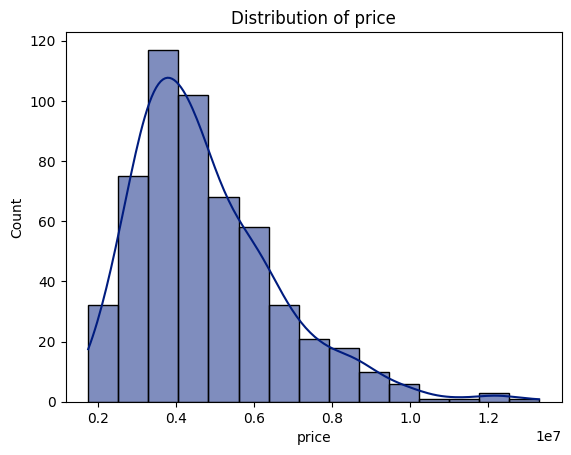

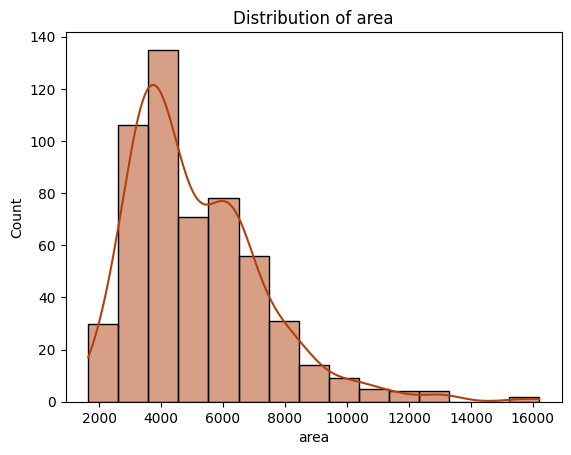

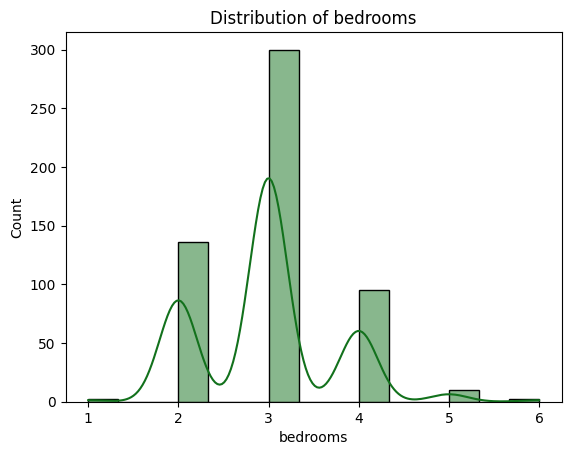

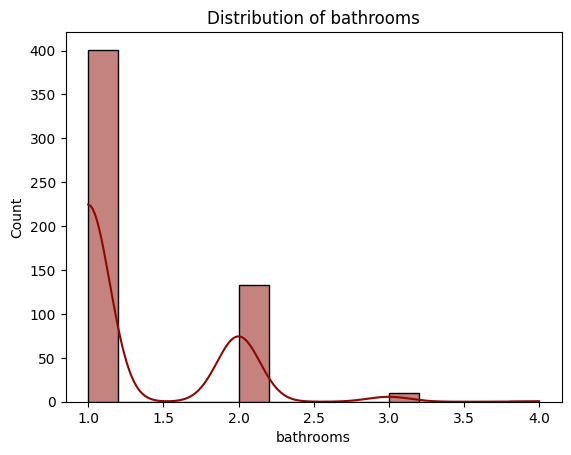

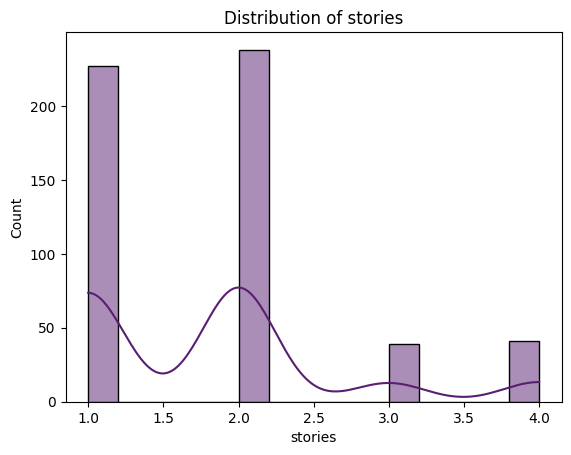

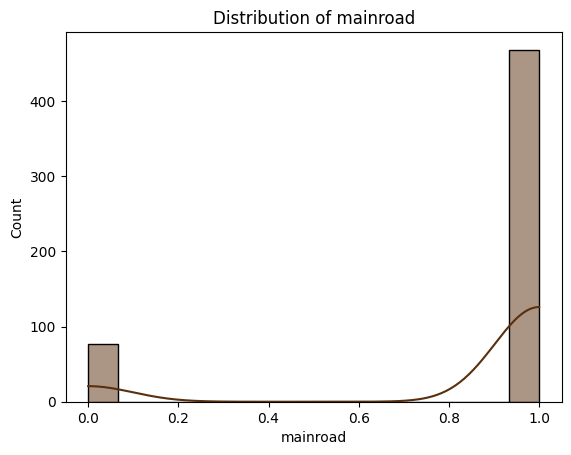

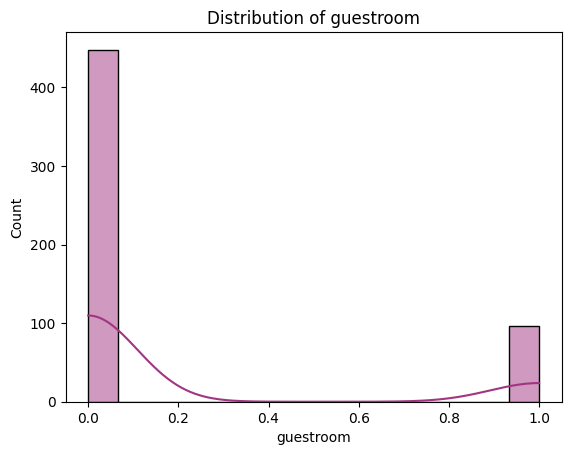

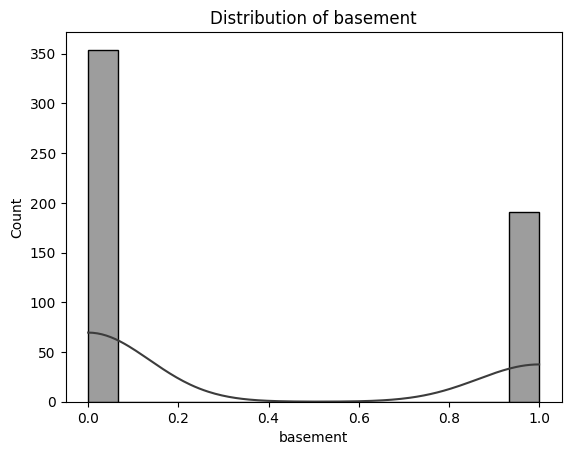

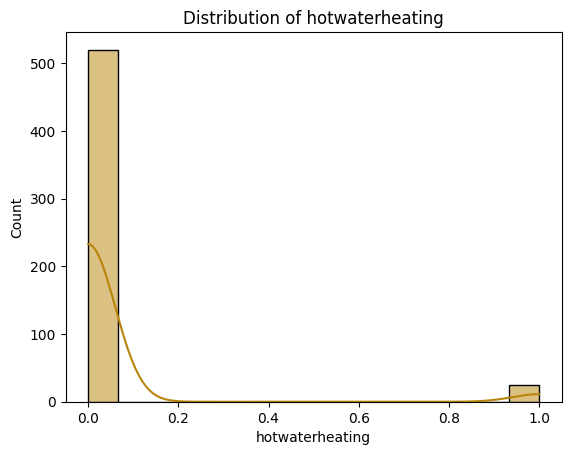

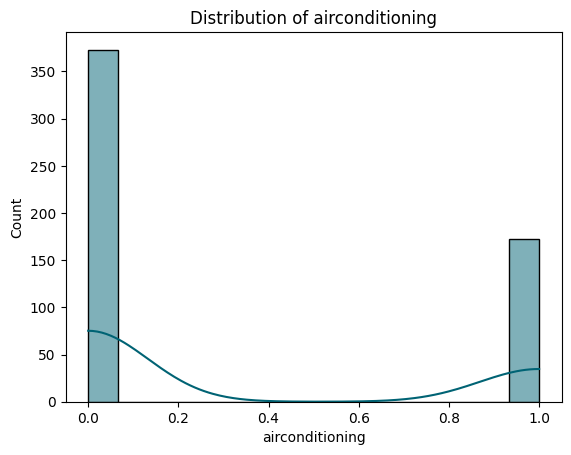

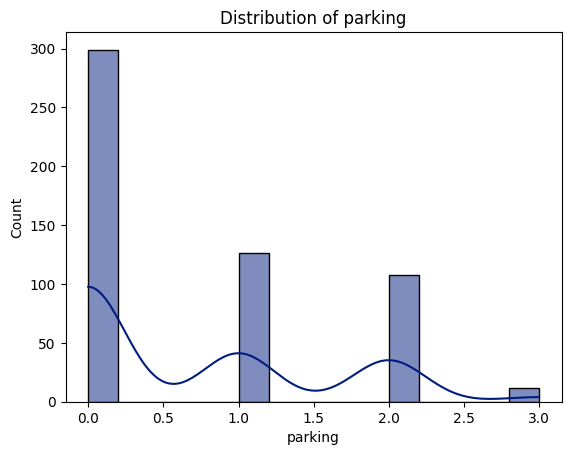

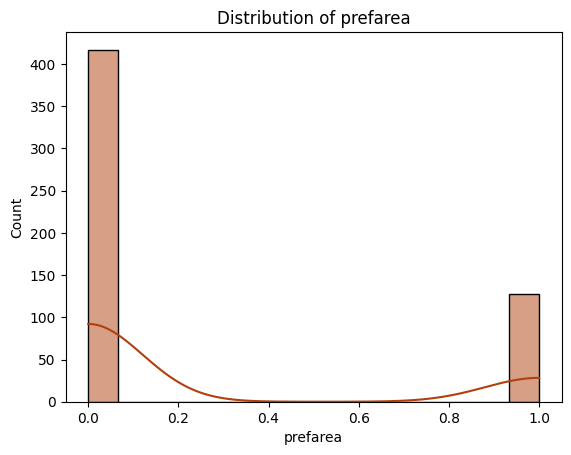

In [5]:
# Feature Cols

def PDP(data):
  """ Function to plot distribution of features """
  columns = [col for col in data.columns]
  colors = sns.color_palette("dark", len(columns))

  for i, col in enumerate(data.select_dtypes(include=['int', 'float']).columns):
      if data[col].value_counts().count() <= 10000:
          sns.histplot(data[col], kde=True, bins=15, color=colors[i % len(colors)])
          plt.title(f'Distribution of {col}')
          plt.show()

PDP(df)

In [6]:
# EDA
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,545.0,4.766729e+06,1.870440e+06,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,5.150541e+03,2.170141e+03,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,2.965138e+00,7.380639e-01,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,1.286239e+00,5.024696e-01,1.0,1.0,1.0,2.0,4.0
stories,545.0,1.805505e+00,8.674925e-01,1.0,1.0,2.0,2.0,4.0
mainroad,545.0,8.587156e-01,3.486347e-01,0.0,1.0,1.0,1.0,1.0
guestroom,545.0,1.779817e-01,3.828487e-01,0.0,0.0,0.0,0.0,1.0
basement,545.0,3.504587e-01,4.775519e-01,0.0,0.0,0.0,1.0,1.0
hotwaterheating,545.0,4.587156e-02,2.093987e-01,0.0,0.0,0.0,0.0,1.0
airconditioning,545.0,3.155963e-01,4.651799e-01,0.0,0.0,0.0,1.0,1.0


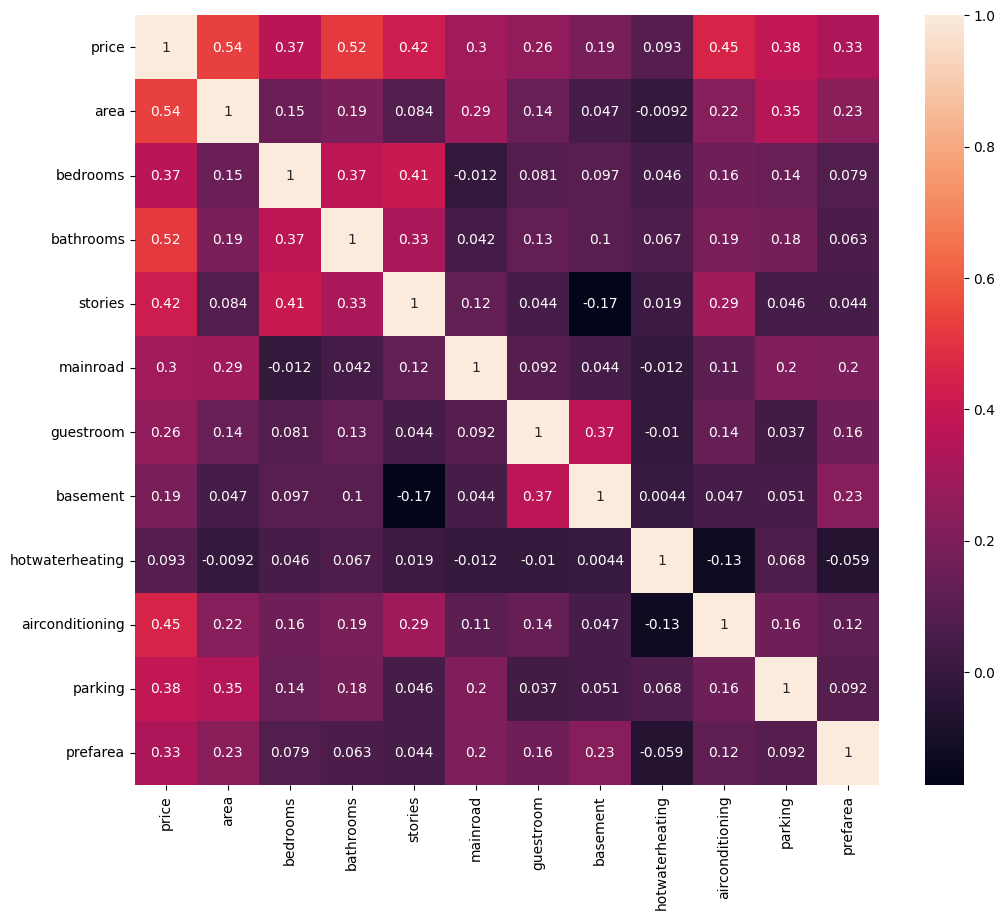

In [7]:
# Feature corrolation
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), annot=True)
plt.show()

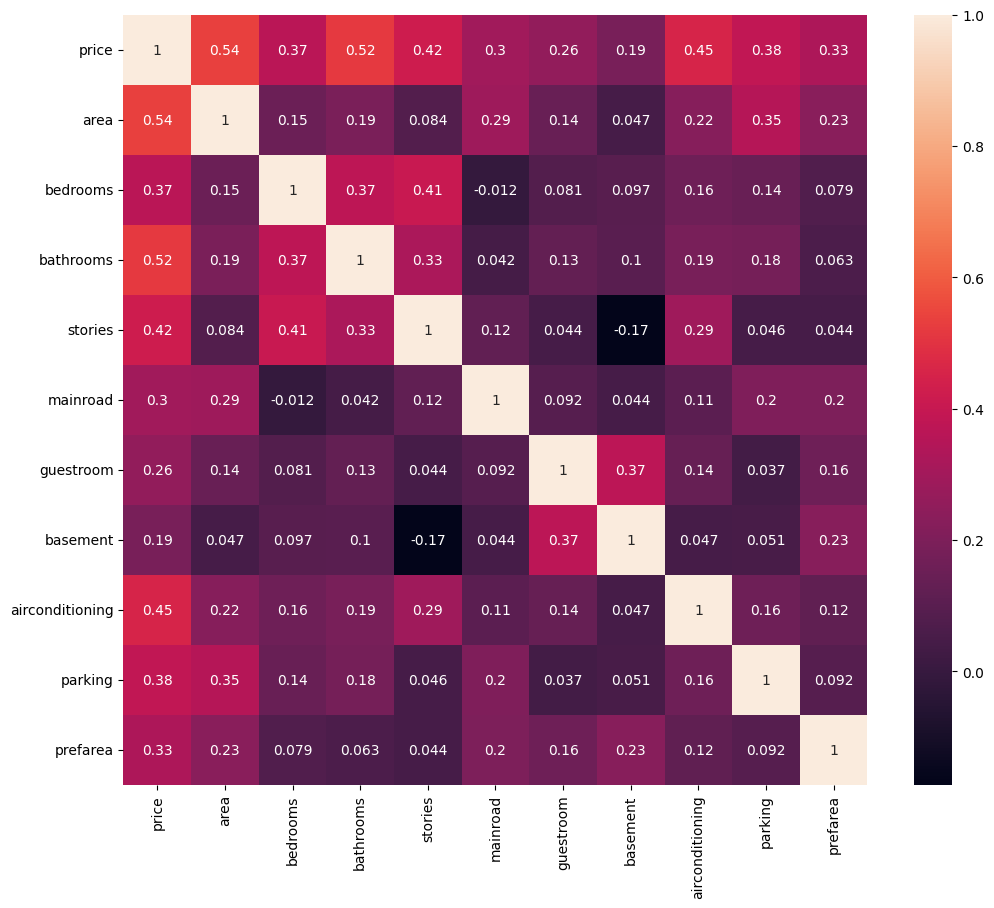

In [8]:
# Remove feaures that are low-corrolated with target value
df.drop(columns=['hotwaterheating'], inplace=True)
numeric_features = df.select_dtypes(include=['int64'])

# Visualize the heatmap of the final features
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_features.corr(), annot=True)
plt.show()

# Train/Test Preparation

In [9]:
# Split the dataset into train and test sets
y = df["price"]
X = df.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (436, 10) (436,)
Test set shape: (109, 10) (109,)


In [11]:
# Standardize the specified numeric features
features_to_standardize = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_standardize] = scaler.fit_transform(X_train[features_to_standardize])
X_test_scaled[features_to_standardize] = scaler.transform(X_test[features_to_standardize])

# Display the shapes of the resulting datasets
print("Training set shape:", X_train_scaled.shape, y_train.shape)
print("Test set shape:", X_test_scaled.shape, y_test.shape)

Training set shape: (436, 10) (436,)
Test set shape: (109, 10) (109,)


In [15]:
# Define the directory to store models
model_dir = 'models'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the scaler as a pickle file in the models directory
scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

# Random Forest Regressor

Train Metrics:  R²=0.944732083892718 & RMSE=170412671257.11658
Test Metrics:  R²=0.5836093702857044 & RMSE=2104675687816.872


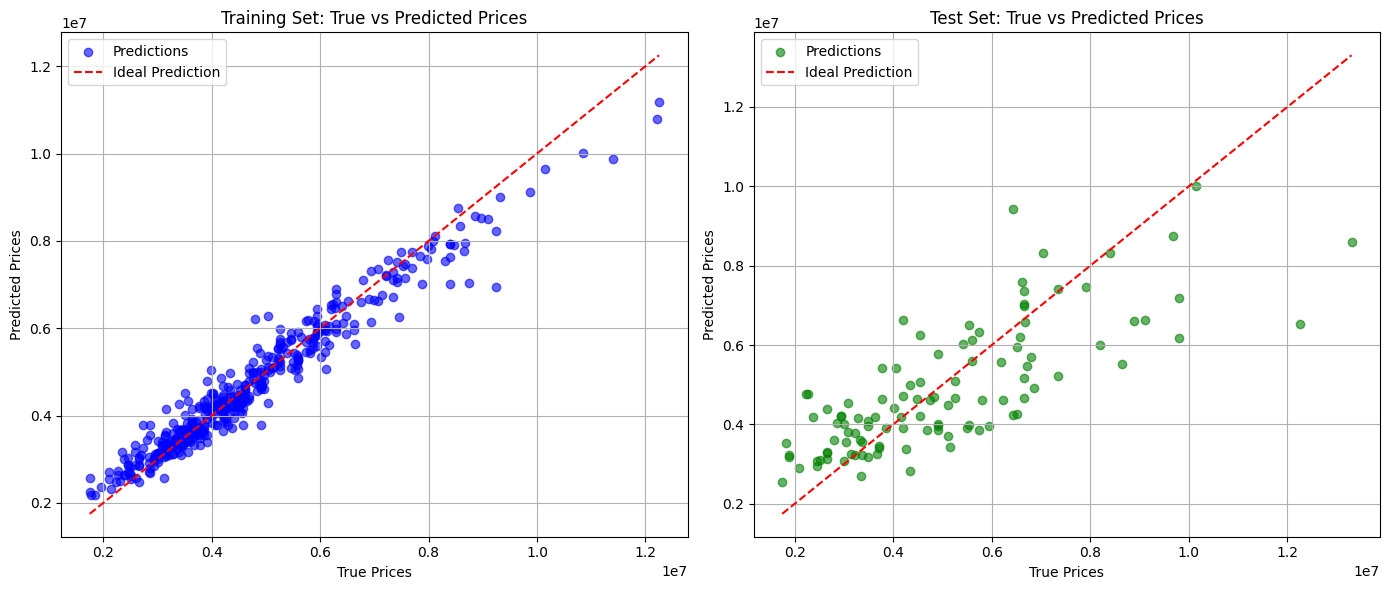

In [21]:
# Dummy trial
# Step 1: Initialize the model
rf_model = RandomForestRegressor(random_state=42)

#Step 2:  Fit the model
rf_model.fit(X_train_scaled, y_train)

# Step 3:  Make predictions
train_predictions = rf_model.predict(X_train_scaled)
test_predictions = rf_model.predict(X_test_scaled)

# Step 4: Evaluate the model
train_r2 = r2_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train Metrics:", f" R²={train_r2} & RMSE={train_mse}")
print("Test Metrics:", f" R²={test_r2} & RMSE={test_mse}")

# Plot predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training set
ax[0].scatter(y_train, train_predictions, color='blue', alpha=0.6, label='Predictions')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[0].set_title('Training Set: True vs Predicted Prices')
ax[0].set_xlabel('True Prices')
ax[0].set_ylabel('Predicted Prices')
ax[0].legend()
ax[0].grid()

# Plot for test set
ax[1].scatter(y_test, test_predictions, color='green', alpha=0.6, label='Predictions')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[1].set_title('Test Set: True vs Predicted Prices')
ax[1].set_xlabel('True Prices')
ax[1].set_ylabel('Predicted Prices')
ax[1].legend()
ax[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

In [22]:
# Hyperparameter Optimisation with optuna
def objective_rf(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 10, 500),
      'max_depth': trial.suggest_int('max_depth', 2, 50),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
      'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  }
  # Create the model
  model = RandomForestRegressor(**params, random_state=42)
  score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
  return np.mean(score)


# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_rf, n_trials=1000, n_jobs=-1)

# Print the best hyperparameters and score
print("Best hyperparameters: ", study.best_params)
print("Best score (negative MSE): ", study.best_value)

[I 2025-01-25 14:15:52,833] A new study created in memory with name: no-name-ba5dbf55-a5a8-4050-9463-c1c352cf1443
[I 2025-01-25 14:15:56,316] Trial 0 finished with value: -1631993608172.5383 and parameters: {'n_estimators': 85, 'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 28, 'max_features': 'log2'}. Best is trial 0 with value: -1631993608172.5383.
[I 2025-01-25 14:15:56,750] Trial 1 finished with value: -1479624575740.2478 and parameters: {'n_estimators': 136, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 1 with value: -1479624575740.2478.
[I 2025-01-25 14:15:56,764] Trial 2 finished with value: -1491917185977.7988 and parameters: {'n_estimators': 64, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 1 with value: -1479624575740.2478.
[I 2025-01-25 14:15:57,120] Trial 6 finished with value: -1325662851207.492 and parameters: {'n_estimators': 425, 'max_depth': 

Best hyperparameters:  {'n_estimators': 53, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best score (negative MSE):  -1141947322135.316


Train Metrics:  R²=0.8775027578442877 & RMSE=377707062753.43616
Test Metrics:  R²=0.5970263834673396 & RMSE=2036858452193.962


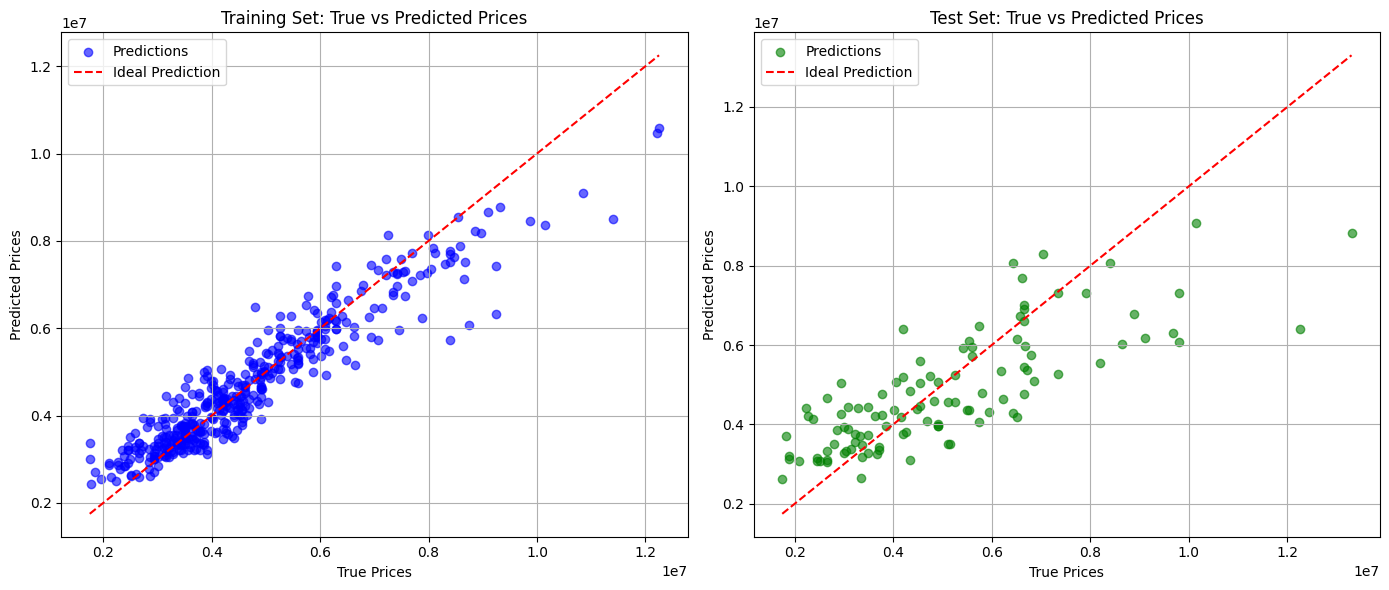

In [23]:
# Initialize the model
rf_model = RandomForestRegressor(**study.best_params, random_state=42)

# Fit the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
train_predictions = rf_model.predict(X_train_scaled)
test_predictions = rf_model.predict(X_test_scaled)

# Evaluate the model
train_r2 = r2_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train Metrics:", f" R²={train_r2} & RMSE={train_mse}")
print("Test Metrics:", f" R²={test_r2} & RMSE={test_mse}")

# Plot predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training set
ax[0].scatter(y_train, train_predictions, color='blue', alpha=0.6, label='Predictions')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[0].set_title('Training Set: True vs Predicted Prices')
ax[0].set_xlabel('True Prices')
ax[0].set_ylabel('Predicted Prices')
ax[0].legend()
ax[0].grid()

# Plot for test set
ax[1].scatter(y_test, test_predictions, color='green', alpha=0.6, label='Predictions')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[1].set_title('Test Set: True vs Predicted Prices')
ax[1].set_xlabel('True Prices')
ax[1].set_ylabel('Predicted Prices')
ax[1].legend()
ax[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

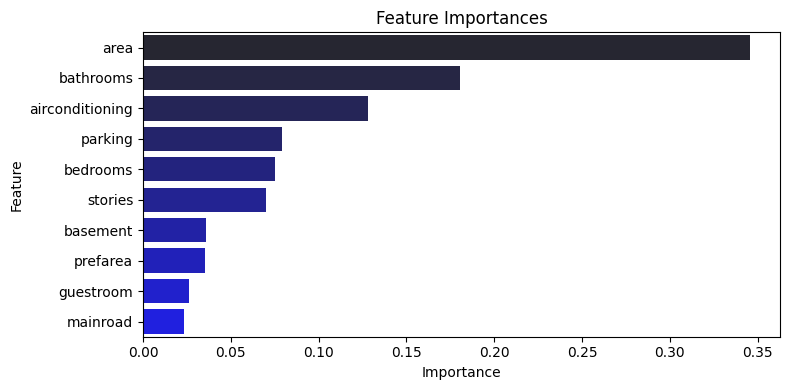

In [26]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature':  X_train.columns[indices],
    'Importance': importances[indices]
})

# Plot using Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='dark:blue', legend=False)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout() 
plt.show()

In [27]:
# Save the trained RF model 
rf_model_path = os.path.join(model_dir, 'rf_model.pkl')
with open(rf_model_path, 'wb') as file:
    pickle.dump(rf_model, file)

# Gradient Boosting Regressor

Train Metrics:  R²=0.9928056001663208 & RMSE=22183157079.51351
Test Metrics:  R²=0.5856378078460693 & RMSE=2094422624556.109


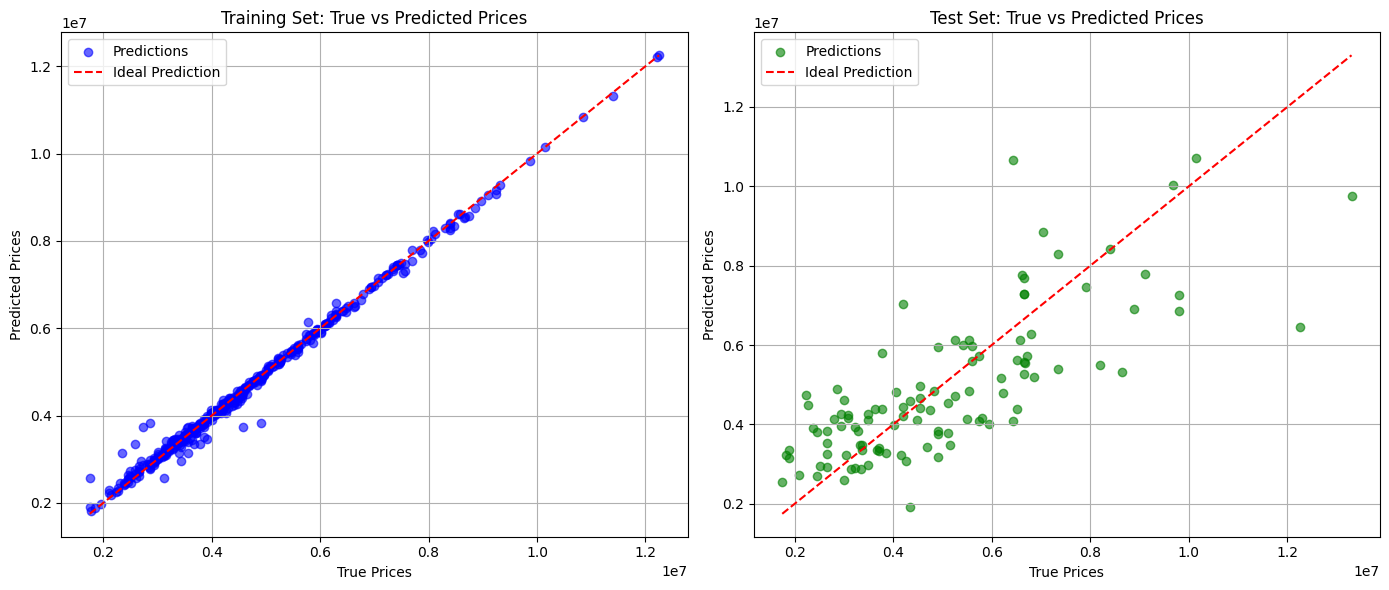

In [12]:
## Dummy Trial
# Step 1: Initialize the model
xgb_model = XGBRegressor(random_state=42)

# Step 2: Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions
train_predictions = xgb_model.predict(X_train_scaled)
test_predictions = xgb_model.predict(X_test_scaled)

# Step 4: Evaluate the model
train_r2 = r2_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train Metrics:", f" R²={train_r2} & RMSE={train_mse}")
print("Test Metrics:", f" R²={test_r2} & RMSE={test_mse}")

# Plot predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training set
ax[0].scatter(y_train, train_predictions, color='blue', alpha=0.6, label='Predictions')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[0].set_title('Training Set: True vs Predicted Prices')
ax[0].set_xlabel('True Prices')
ax[0].set_ylabel('Predicted Prices')
ax[0].legend()
ax[0].grid()

# Plot for test set
ax[1].scatter(y_test, test_predictions, color='green', alpha=0.6, label='Predictions')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[1].set_title('Test Set: True vs Predicted Prices')
ax[1].set_xlabel('True Prices')
ax[1].set_ylabel('Predicted Prices')
ax[1].legend()
ax[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

In [13]:
# Hyperparameter Optimization with Optuna
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    # Create the model
    model = XGBRegressor(**params, random_state=42)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    
    return np.mean(score)

# Create a study
study = optuna.create_study(direction='maximize')

# Optimize the study
study.optimize(objective_xgb, n_trials=1000, n_jobs=-1)

# Print the best hyperparameters and score
print("Best hyperparameters: ", study.best_params)
print("Best score (negative MSE): ", study.best_value)

[I 2025-01-25 14:07:28,249] A new study created in memory with name: no-name-6be64a96-0701-4bc0-b1a2-e8b55d13a109
[I 2025-01-25 14:07:33,073] Trial 2 finished with value: -1269455679067.027 and parameters: {'n_estimators': 17, 'max_depth': 49, 'learning_rate': 0.22104640004842754, 'subsample': 0.5206216069206825, 'colsample_bytree': 0.7720927995455246, 'gamma': 0.22878311077119184, 'reg_alpha': 1.8604549728569668, 'reg_lambda': 4.312925596115604}. Best is trial 2 with value: -1269455679067.027.
[I 2025-01-25 14:07:33,659] Trial 0 finished with value: -1321717483577.307 and parameters: {'n_estimators': 450, 'max_depth': 18, 'learning_rate': 0.23422832260692134, 'subsample': 0.6915280141335396, 'colsample_bytree': 0.7542450441791082, 'gamma': 1.3243099422316063, 'reg_alpha': 2.513229645517222, 'reg_lambda': 2.826301615999082}. Best is trial 2 with value: -1269455679067.027.
[I 2025-01-25 14:07:33,913] Trial 7 finished with value: -1214246965594.6082 and parameters: {'n_estimators': 142, 

Best hyperparameters:  {'n_estimators': 103, 'max_depth': 4, 'learning_rate': 0.062432546177788685, 'subsample': 0.571318842682939, 'colsample_bytree': 0.5406698234447574, 'gamma': 3.3036265402721465, 'reg_alpha': 1.8947207085344586, 'reg_lambda': 1.5551987158306235}
Best score (negative MSE):  -1111764054156.7883


Train Metrics:  R²=0.8309905529022217 & RMSE=521122525782.7477
Test Metrics:  R²=0.6135744452476501 & RMSE=1953215213229.9272


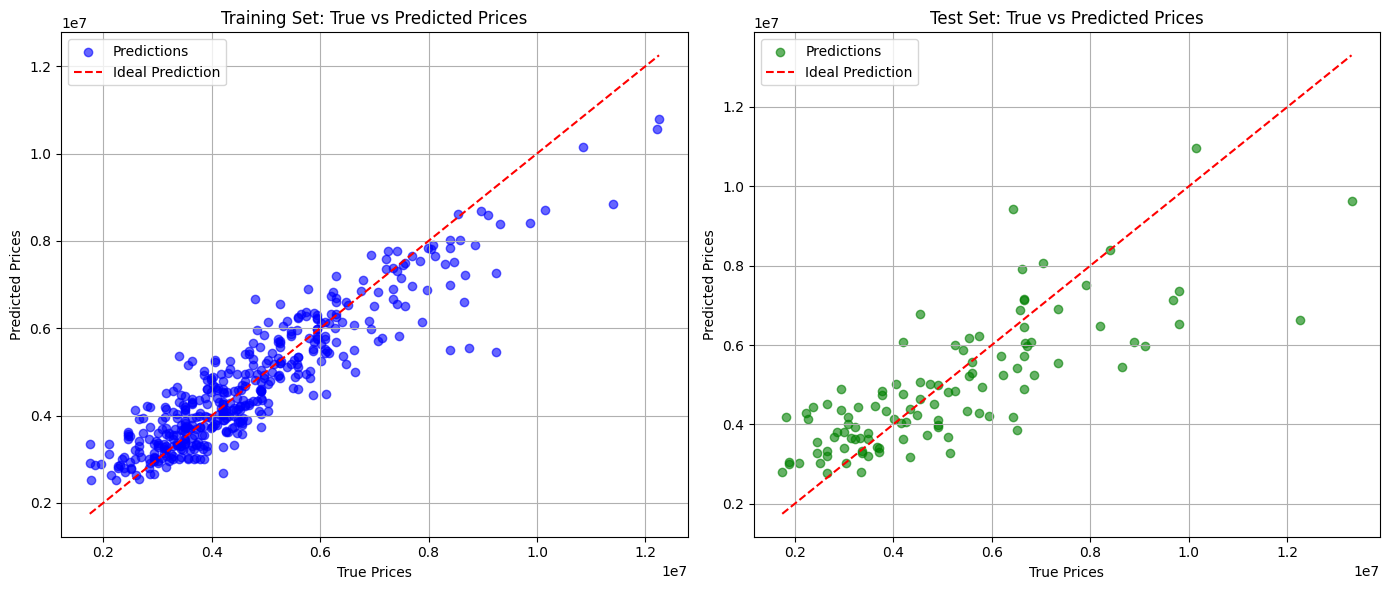

In [14]:
#  Initialize the model
xgb_model = XGBRegressor(**study.best_params, random_state=42)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)

# Step 3: Make predictions
train_predictions = xgb_model.predict(X_train_scaled)
test_predictions = xgb_model.predict(X_test_scaled)

# Evaluate the model
train_r2 = r2_score(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train Metrics:", f" R²={train_r2} & RMSE={train_mse}")
print("Test Metrics:", f" R²={test_r2} & RMSE={test_mse}")

# Plot predictions
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for training set
ax[0].scatter(y_train, train_predictions, color='blue', alpha=0.6, label='Predictions')
ax[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[0].set_title('Training Set: True vs Predicted Prices')
ax[0].set_xlabel('True Prices')
ax[0].set_ylabel('Predicted Prices')
ax[0].legend()
ax[0].grid()

# Plot for test set
ax[1].scatter(y_test, test_predictions, color='green', alpha=0.6, label='Predictions')
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
ax[1].set_title('Test Set: True vs Predicted Prices')
ax[1].set_xlabel('True Prices')
ax[1].set_ylabel('Predicted Prices')
ax[1].legend()
ax[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

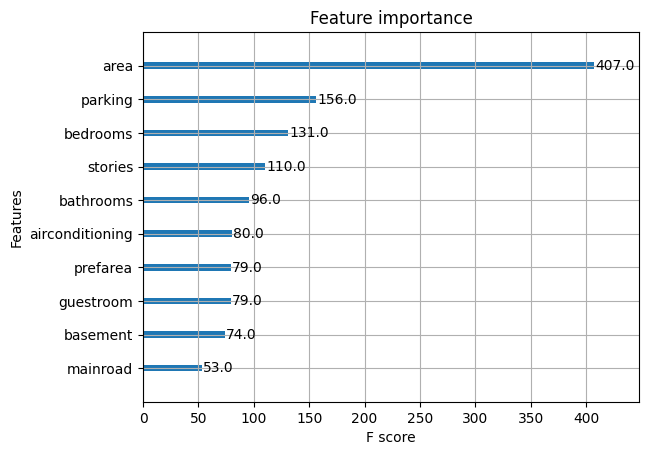

In [16]:
# Plot Fetures imoprtances
plot_importance(xgb_model, importance_type='weight')
plt.show()

In [20]:
# Save the trained XGB model 
xgb_model_path = os.path.join(model_dir, 'xgb_model.pkl')
with open(xgb_model_path, 'wb') as file:
    pickle.dump(xgb_model, file)